In [1]:
import pandas as pd
import numpy as np
import sys
import pickle

sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import evaluate

import xgboost as xgb
from sklearn.linear_model import LinearRegression,LogisticRegression

(CVXPY) Jul 03 06:17:22 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 03 06:17:22 PM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 03 06:17:22 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Module

In [2]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="regression_delta", #option: regression, regression_delta, classification, binary_classification
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation='KNN', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    save_csv=False, 
    random_state=2022)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Missing values in train before imputation: 122
Missing values in train after imputation: 0
Missing values in test before imputation: 24
Missing values in test after imputation: 0
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Train.csv
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Test.csv


In [3]:
# read train, test from dataloader
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [4]:
train

,grp,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,delta
0,1.0,54.0,1.0,0.0,7.0,1.0,225.0,31.377703,71.0,3.0,...,50.0,25.0,0.285714,25.0,1.64,144.000000,886.000000,113.000000,3.189429,1.456239
1,1.0,54.0,0.0,0.0,7.0,1.0,175.0,28.242654,66.0,3.0,...,35.0,17.0,0.250000,25.0,1.19,207.000000,1010.000000,56.000000,2.935127,0.461251
2,1.0,63.0,0.0,0.0,7.0,1.0,117.0,20.080811,64.0,0.0,...,40.0,10.0,0.000000,5.0,0.40,190.000000,657.000000,100.000000,2.698947,-0.687875
3,1.0,61.0,0.0,0.0,7.0,1.0,240.0,39.933728,65.0,2.0,...,55.0,50.0,0.250000,60.0,1.00,44.000000,948.000000,51.000000,3.719481,-0.725467
4,1.0,64.0,1.0,0.0,7.0,1.0,294.0,41.000198,71.0,2.0,...,55.0,55.0,0.285714,70.0,16.74,178.000000,882.000000,87.000000,5.146565,2.300292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1.0,42.0,0.0,2.0,7.0,1.0,156.0,29.472722,61.0,0.0,...,55.0,80.0,1.000000,80.0,7.33,353.000000,859.000000,211.000000,5.167880,1.481994
342,2.0,49.0,0.0,0.0,1.0,1.0,220.0,33.447232,68.0,2.0,...,35.0,50.0,0.000000,15.0,22.36,266.000000,1330.000000,253.000000,4.272186,-0.186939
343,1.0,24.0,0.0,0.0,1.0,1.0,128.0,20.045444,67.0,2.0,...,75.0,60.0,0.500000,60.0,6.47,289.000000,1800.000000,188.000000,4.333871,2.224753
344,2.0,61.0,0.0,0.0,7.0,1.0,125.0,20.798817,65.0,0.0,...,35.0,15.0,0.000000,15.0,0.92,163.000000,1500.000000,44.000000,3.283134,2.235549


In [5]:
# get x,y train and test set
X_train = train.iloc[:,:-1] # train.iloc[:,-2]
y_train = train.iloc[:,-1] 
X_test = test.iloc[:,:-1] # test.iloc[:,-2]
y_test = test.iloc[:,-1]

In [6]:
# initialize evaluation module
aml = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC", challenge=dataset.challenge)

# Model Module

In [7]:
# modelmodule
if "regression" in dataset.challenge:
    model_id = 'xgb'
    save_path = f'../Models/{dataset.challenge}_{model_id}.pkl'
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    # optional, to save and load models using pickle
    pickle.dump(model, open(save_path, 'wb'))
    model = pickle.load(open(save_path, 'rb'))
    
    aml.evaluate(model_id, model, test)
elif "classification" in dataset.challenge:
    model = xgb.XGBClassifier(use_label_encoder=False)
    model.fit(X_train, y_train)
    aml.evaluate("xgb", model, test)

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [8]:
# linear model
if "regression" in dataset.challenge:
    model = LinearRegression()
    model.fit(X_train, y_train)
    aml.evaluate("lr", model, test) # input: model and test
elif "classification" in dataset.challenge:
    model = LogisticRegression()
    model.fit(X_train, y_train)
    aml.evaluate("lr", model, test) # input: model and test

In [9]:
X_test

,grp,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,...,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M
0,0.0,62.0,1.0,0.0,7.0,1.0,219.0,28.114865,74.0,2.0,...,3.0,35.0,10.0,0.000000,10.0,4.41,284.000000,1640.00000,94.000000,3.444942
1,1.0,54.0,0.0,2.0,7.0,1.0,160.0,26.622485,65.0,0.0,...,7.0,65.0,70.0,0.750000,60.0,51.51,462.000000,939.00000,49.000000,5.588392
2,2.0,35.0,0.0,0.0,7.0,1.0,211.0,36.214111,64.0,2.0,...,1.0,25.0,55.0,0.625000,60.0,3.60,219.000000,1160.00000,138.000000,3.119380
3,1.0,42.0,1.0,0.0,7.0,1.0,185.0,26.541837,70.0,3.0,...,8.0,39.0,35.0,0.000000,35.0,5.30,231.000000,1340.00000,118.000000,4.156756
4,2.0,72.0,0.0,2.0,7.0,1.0,152.0,24.530762,66.0,3.0,...,6.0,50.0,65.0,0.857143,50.0,4.75,657.000000,1480.00000,317.000000,4.437767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2.0,52.0,1.0,0.0,7.0,1.0,256.0,32.864865,74.0,3.0,...,4.0,25.0,30.0,0.000000,20.0,6.79,242.632801,1237.34229,68.525678,3.799023
82,1.0,62.0,0.0,0.0,1.0,1.0,273.0,45.424615,65.0,0.0,...,4.0,60.0,20.0,0.428571,50.0,2.01,561.000000,1410.00000,198.000000,3.316698
83,1.0,56.0,0.0,0.0,7.0,1.0,128.0,24.182747,61.0,1.0,...,7.0,70.0,60.0,0.142857,20.0,8.73,188.000000,1320.00000,138.000000,4.841508
84,3.0,74.0,1.0,0.0,7.0,1.0,230.0,31.190201,72.0,2.0,...,17.0,65.0,25.0,0.000000,25.0,1.35,168.000000,1360.00000,69.000000,5.080998


# Evaluation on test set

In [10]:
regression, classification = aml.leaderboard()

In [11]:
regression

,model,MAE,MSE,RMSE,R2,Pearson_Correlation
0,xgb,1.054843,1.663887,1.289918,-0.206502,0.204866
1,lr,1.037648,1.643516,1.281997,-0.191730,0.262042


In [12]:
classification

,model,Accuracy,F1-Score
0,xgb,0.406977,0.359790
1,lr,0.441860,0.428713


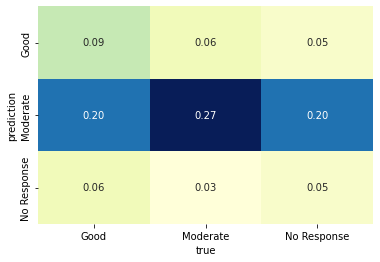

In [13]:
# rows: true, columns: pred
aml.confusion_matrix("xgb",plot=True, normalize=True)

In [14]:
# true
aml.saved_model['xgb'][0].value_counts()

Moderate       31
Good           30
No Response    25
dtype: int64

In [15]:
# pred
aml.saved_model['xgb'][1].value_counts()

Moderate       57
Good           17
No Response    12
dtype: int64

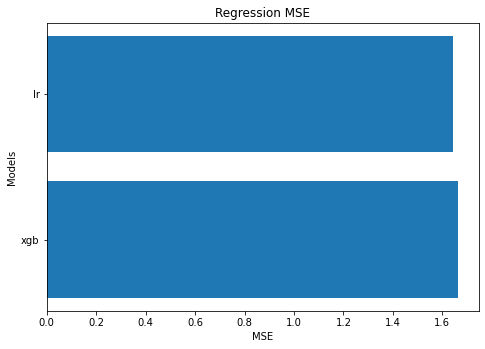

In [16]:
aml.plot_results('regression','MSE')

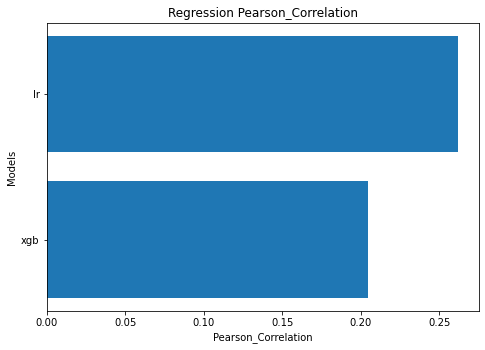

In [17]:
aml.plot_results('regression','Pearson_Correlation')

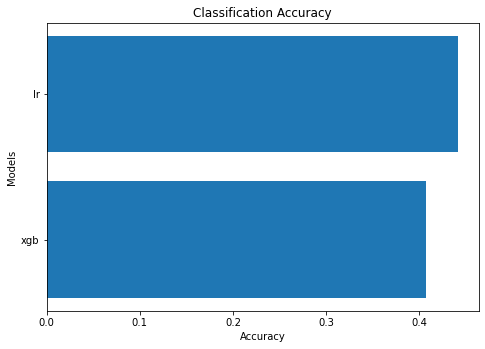

In [18]:
aml.plot_results('classification','Accuracy')